In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [9]:
df = pd.read_csv('iso.csv')
df = df[df['r1_charge_heater'] >= 0]

/tmp/ipykernel_4247/4025882009.py:36: RuntimeWarning: Mean of empty slice
  mean_trace = np.nanmean(trace_chs, axis=0)
/home/mmkhajah/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmkhajah/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


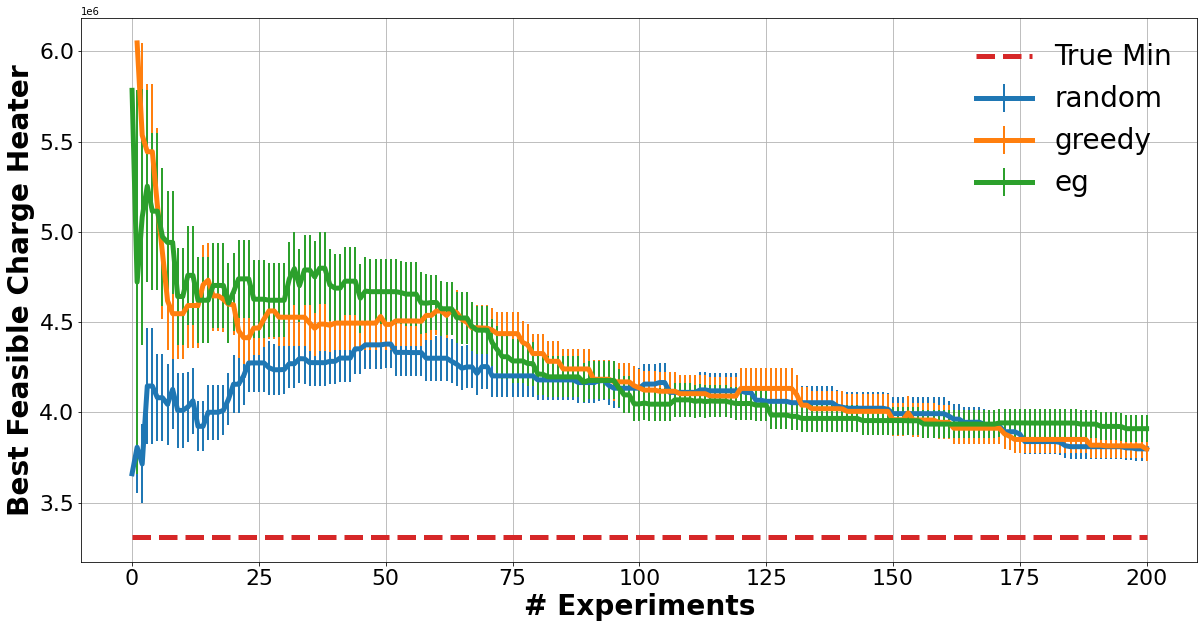

In [146]:
exp = 'noiseless_83_99'
with open("exp_cfgs/%s.json" % exp, 'r') as f:
    exp_cfg = json.load(f)

min_ron = exp_cfg['min_ron']
min_yield = exp_cfg['min_yield']
models = ['random', 'greedy', 'eg']
paths = [(m, "traces/%s_%s.json" % (exp, m)) for m in models]
valid_comb_ix =(df['process_ron'] >= min_ron) & (df['process_yield'] >= min_yield)

f, ax = plt.subplots(1, 1, figsize=(20, 10))
for name,p in paths:
    
    with open(p, 'r') as f:
        results = json.load(f)
    
#     trace_chs = []
#     for r in results['traces']:
#         sdf = df.iloc[r]
#         fix = (sdf['process_ron'] >= min_ron) & (sdf['process_yield'] >= min_yield)
#         chs = np.array(sdf['r1_charge_heater'])
#         chs[~fix] = np.inf
#         trace_chs.append(np.minimum.accumulate(chs))
    
    trace_chs = []
    for r in results['obs_traces']:
        r = np.array(r)
        fix = (r[:,1] >= min_ron) & (r[:,2] >= min_yield)
        r[~fix,0] = np.inf
        trace_chs.append(np.minimum.accumulate(r[:,0]))
    
    trace_chs = np.array(trace_chs)
    trace_chs[np.isinf(trace_chs)] = np.nan
    reps = np.sum(~np.isnan(trace_chs), axis=0)
    
    mean_trace = np.nanmean(trace_chs, axis=0)
    stderr_trace = np.nanstd(trace_chs, axis=0, ddof=1) / np.sqrt(reps)
    
    ax.errorbar(np.arange(mean_trace.shape[0]), mean_trace, yerr=stderr_trace, linewidth=5, label=name, marker='o', markersize=2, elinewidth=2)
    #ax.plot(, )

ax.plot(np.arange(mean_trace.shape[0]), np.ones(mean_trace.shape[0]) * 
        np.min(df[valid_comb_ix]['r1_charge_heater']), linewidth=5, linestyle='--', label='True Min')
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.set_xlabel('# Experiments', fontsize=28, fontweight='bold')
ax.set_ylabel('Best Feasible Charge Heater', fontsize=28, fontweight='bold')
ax.grid(True)
ax.legend(fontsize=28, frameon=False)